## Table of contents
1. [data coverage (Fig. S3a)](#coverage)
2. [reproducibility (Fig. S3b)](#reproducibility)
3. [TF-dependent activity of 1373 promoters (Fig. 1d)](#scatter)
4. [benchmark (Fig. S6)](#benchmark)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_context("poster")
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# data load
log_GFP = pd.read_csv('../Processed_data/normalized_stat_exp.csv')
log_GFP_nc = pd.read_csv('../Processed_data/normalized_stat_nc.csv')

## data coverage <a name="coverage"></a>

In [3]:
median_log_GFP_promoter = log_GFP.groupby('operon')['mean'].median()
quantifiable_promoters = log_GFP[log_GFP['operon'].isin(median_log_GFP_promoter[median_log_GFP_promoter.notna()].index)]
n_rep_mat = quantifiable_promoters.pivot(index='operon', columns='sgRNA', values='n_rep')
n_rep_mat.index.name = 'promoter'
n_rep_mat.columns.name = 'TF gene'

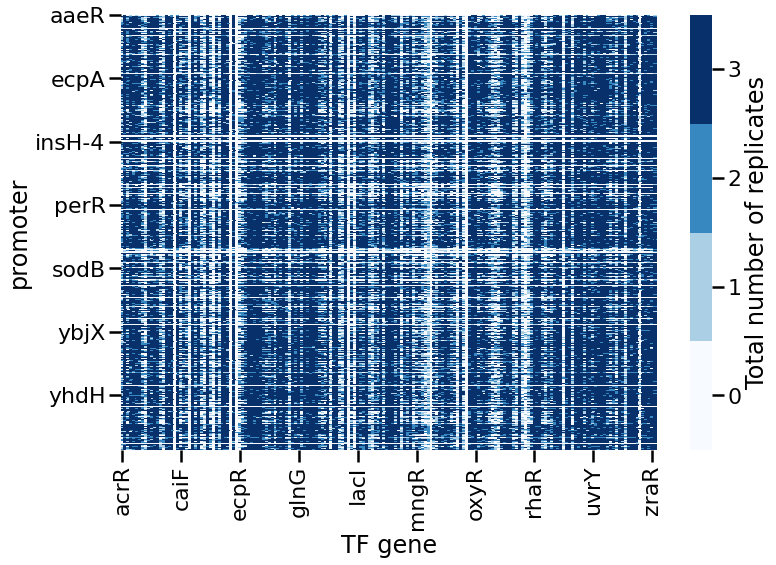

In [4]:
# Fig. S3a left
fig,ax = plt.subplots(1,1,figsize=(12,8))
sns.heatmap(data = n_rep_mat, 
            cmap=plt.get_cmap("Blues", 4), 
            vmin=-0.5, vmax=3.5, 
            xticklabels = 20, 
            yticklabels = 200, 
            ax = ax)
colorbar = ax.collections[0].colorbar
colorbar.set_label("Total number of replicates")
colorbar.set_ticks([0,1,2,3])

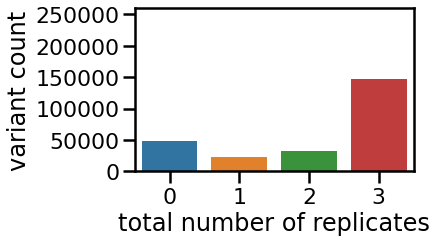

In [5]:
# Fig. S3b right
def count_variants(x, data = quantifiable_promoters['n_rep']):
    return (data==x).sum()
    
fig,ax = plt.subplots(1,1,figsize=(5,3))
x = [0,1,2,3]
sns.barplot(x = x, y = list(map(count_variants, x)),  ax = ax)
ax.set(ylim=(0, 2.6e5), yticks = np.linspace(0,2.5e5,6));
ax.set(xlabel='total number of replicates', 
       ylabel='variant count');

## reproducibility <a name="reproducibility"></a>

In [6]:
rescaled_mean = pd.read_csv('../Processed_data/normalized_rep_mean_value.csv')
rescaled_mean.set_index(['operon','sgRNA'], inplace = True)

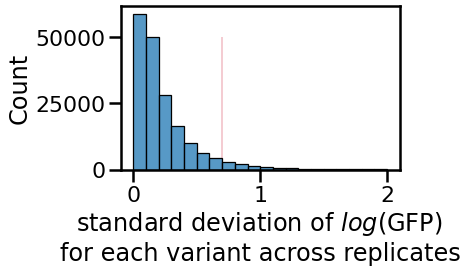

In [7]:
# Fig. S3b left
LOG_STD_CUTOFF = 0.7
fig,ax = plt.subplots(1,1,figsize=(5,3))
sns.histplot(rescaled_mean.std(1), bins = np.linspace(0,2,21), ax = ax);
sns.lineplot(x = [LOG_STD_CUTOFF, LOG_STD_CUTOFF], y = [0, 5e4], color = np.array([202,0,32])/255, ax = ax);
ax.set(xlabel='standard deviation of $log$(GFP) \nfor each variant across replicates');

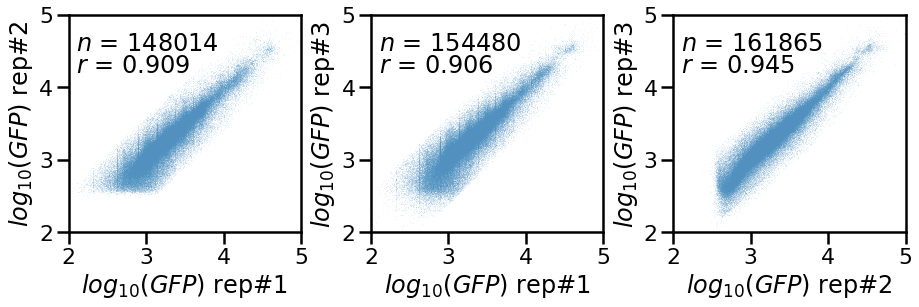

In [8]:
# Fig. S3b right
dataset = rescaled_mean[rescaled_mean.std(1)<0.7]/np.log(10)
fig, axes = plt.subplots(1,3, figsize=(15,4))
xs = ['rep1','rep1','rep2']
ys = ['rep2','rep3','rep3']
xlabels = ['$log_{10}(GFP)$ rep#1', '$log_{10}(GFP)$ rep#1', '$log_{10}(GFP)$ rep#2']
ylabels = ['$log_{10}(GFP)$ rep#2', '$log_{10}(GFP)$ rep#3', '$log_{10}(GFP)$ rep#3']
for i in range(3):
    sns.scatterplot(data = dataset, x = xs[i], y = ys[i], s = 1, alpha = 0.1, ax = axes[i])
#     sns.regplot(data = dataset, x = xs[i], y = ys[i], scatter = False, ax = axes[i])
    axes[i].set(xlim=[2,5.0], 
                ylim=[2,5.0],
                xticks = [2,3,4,5],
                yticks = [2,3,4,5],
                xlabel=xlabels[i],
                ylabel=ylabels[i],
               )
    quantifiable_bool = (dataset[xs[i]].notna())&(dataset[ys[i]].notna())
    N = quantifiable_bool.sum()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataset[xs[i]][quantifiable_bool], dataset[ys[i]][quantifiable_bool])
    axes[i].annotate("$r$ = {:.3f}".format(r_value), (2.1, 4.2));
    axes[i].annotate("$n$ = {}".format(N), (2.1, 4.5));
plt.subplots_adjust(wspace=0.3)

## TF-dependent activity of 1373 promoters <a name="scatter"></a>

In [9]:
# obtain (promoter x TF gene) matrix
# the last two columns are median activity across all TFKD conditions and mean activity in negative controls  
log_GFP_mat = quantifiable_promoters[quantifiable_promoters['std']<0.7].pivot(index='operon', columns='sgRNA', values='mean')
log_GFP_mat['median'] = log_GFP_mat.median(1)
nc_mean_series = log_GFP_nc[log_GFP_nc['mean'].notna()].set_index('operon')['mean'].rename('nc_mean')
log_GFP_mat = pd.concat([log_GFP_mat, nc_mean_series],axis = 1)
log_GFP_mat = log_GFP_mat[(log_GFP_mat['median'].notna())&(log_GFP_mat['nc_mean'].notna())]
log_GFP_mat = log_GFP_mat/np.log(10)
log_GFP_mat = log_GFP_mat.sort_values(by=['median']).reset_index()

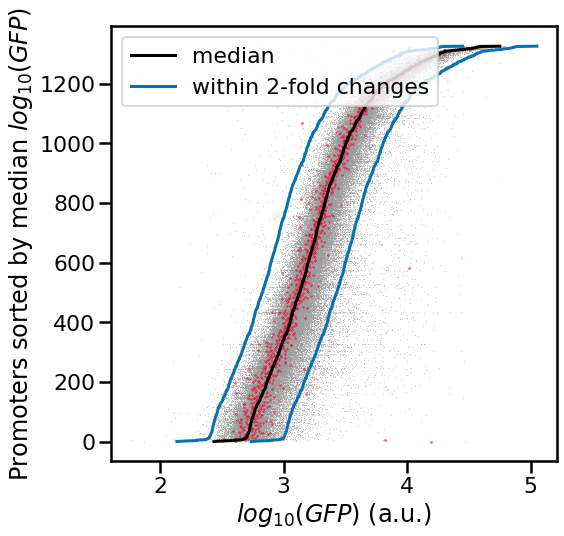

In [10]:
# Fig. 1d
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
sns.scatterplot(x = log_GFP_mat.iloc[:,1:-2].to_numpy().reshape(-1), y = log_GFP_mat.index.repeat(log_GFP_mat.shape[1]-3), s = 1, alpha = 0.5, color = np.array([125,125,125])/255, ax = ax)
sns.scatterplot(x = log_GFP_mat['nc_mean'], y = log_GFP_mat.index, s = 10, alpha = 0.5, color = np.array([202,0,32])/255, ax = ax)
sns.lineplot(x = log_GFP_mat['median'], y = log_GFP_mat.index, color='k', label = 'median', ax = ax)
sns.lineplot(x = log_GFP_mat['median']+np.log10(2), y = log_GFP_mat.index, color=np.array([5,113,176])/255, label = 'within 2-fold changes', ax = ax)
sns.lineplot(x = log_GFP_mat['median']-np.log10(2), y = log_GFP_mat.index, color=np.array([5,113,176])/255, ax = ax)
ax.set(xlabel = "$log_{10}(GFP)$ (a.u.)", ylabel = "Promoters sorted by median $log_{10}(GFP)$");

## benchmark using individual measurements  <a name="benchmark"></a>

In [11]:
def read_platereader_measurement(start_row):
    benchmark_LTP_data = pd.read_excel('../Platereader_data/six_random_promoters.xls', 
              sheet_name = 'stat', skiprows = start_row-1,  nrows= 5, usecols = 'C:L', header=None, 
              names = ['fadR','marR','acrR','crp','arcA','marA','lacI','purR','metJ','NC_84'],)
    benchmark_LTP_data['operon'] = ['fadE','marRAB','lacZYA','metA','glyA']
    benchmark_LTP_data = benchmark_LTP_data.melt(id_vars='operon',var_name='sgRNA',value_name='expression').sort_values(by=['operon', 'sgRNA'],ignore_index=True)
    benchmark_LTP_data['expression'] = np.log10(benchmark_LTP_data['expression'])
    benchmark_LTP_data.set_index(['operon', 'sgRNA'], inplace=True)
    return benchmark_LTP_data

In [12]:
# read plate reader data
# individual replicates
benchmark_LTP_data_rep1 = read_platereader_measurement(3)
benchmark_LTP_data_rep2 = read_platereader_measurement(10)
benchmark_LTP_data_rep3 = read_platereader_measurement(17)
# average
benchmark_LTP_data = read_platereader_measurement(24)
# combine all measurements from 3 replicates
benchmark_LTP_data_all = pd.concat([benchmark_LTP_data_rep1,benchmark_LTP_data_rep2,benchmark_LTP_data_rep3])
LTP_mean = pd.concat([benchmark_LTP_data_rep1,benchmark_LTP_data_rep2,benchmark_LTP_data_rep3],axis=1).mean(1)
LTP_std = pd.concat([benchmark_LTP_data_rep1,benchmark_LTP_data_rep2,benchmark_LTP_data_rep3],axis=1).std(1)

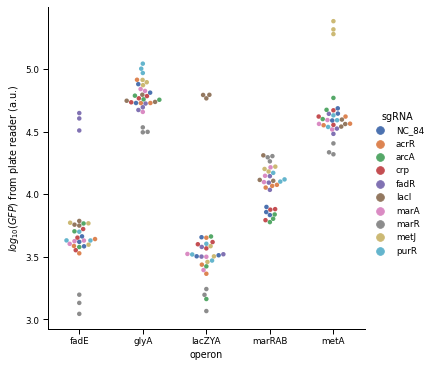

In [13]:
# Fig. S6a
sns.set_context("paper")
g = sns.catplot(data = benchmark_LTP_data_all.reset_index(), x = 'operon', y = 'expression', hue = 'sgRNA', kind='swarm', palette='deep', s = 4.5, height = 5, aspect=1)
g.set_ylabels("$log_{10}(GFP)$ from plate reader (a.u.)");

In [14]:
benchmark_comparison = pd.concat([(rescaled_mean.mean(axis=1).rename('PPTP_mean')/np.log(10)),
                                  (rescaled_mean.std(axis=1).rename('PPTP_std')/np.log(10)),
                                  LTP_mean.rename('PlateReader_mean'),
                                  LTP_std.rename('PlateReader_std')], 
                                 join = 'inner', axis = 1).reset_index()
benchmark_comparison['PPTP_response'] = ((benchmark_comparison['PPTP_mean']
                                        - benchmark_comparison[benchmark_comparison['sgRNA']=='NC_84']['PPTP_mean'].repeat(10).values)
                                        /np.log10(2))

slope:  1.091, r:  0.954, N: 45


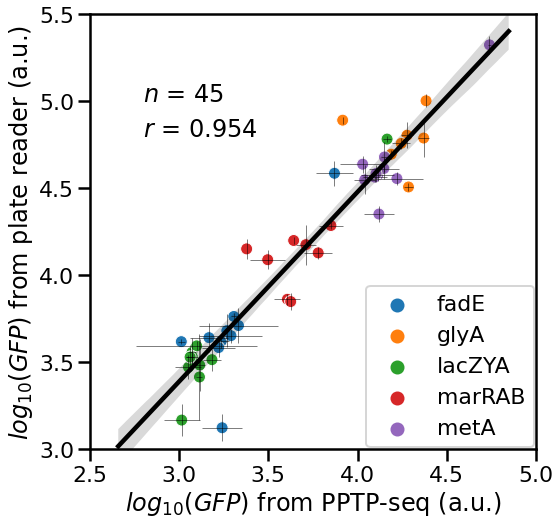

In [15]:
# Fig. S6b
sns.set_context("poster")
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
pptp_seq_mean = 'PPTP_mean'
pptp_seq_std = 'PPTP_std'
plate_reader_mean = 'PlateReader_mean'
plate_reader_std = 'PlateReader_std'
condition = (benchmark_comparison[pptp_seq_mean]>0) #& (benchmark_comparison[pptp_seq_std]<0.7) #& (benchmark_comparison[sort_seq_std]>0)
data=benchmark_comparison#[condition]

ax.errorbar(x = data[pptp_seq_mean],
            y = data[plate_reader_mean],
            xerr=data[pptp_seq_std],
            yerr=data[plate_reader_std],
            linewidth=1, linestyle='', color='k', alpha=0.5)
sns.scatterplot(data = data, 
                x = pptp_seq_mean, 
                y = plate_reader_mean,
                hue='operon', ax=ax);
ax.legend(loc=4, borderaxespad=0.1)
sns.regplot(data=benchmark_comparison[condition],
            x=pptp_seq_mean,
            y=plate_reader_mean, 
            scatter=False, 
            color='k',
            truncate=False, 
            ax=ax);
ax.set(xlim=(2.5, 5), 
       ylim=(3, 5.5), 
       xlabel='$log_{10}(GFP)$ from PPTP-seq (a.u.)', 
       ylabel='$log_{10}(GFP)$ from plate reader (a.u.)');
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(benchmark_comparison[condition][pptp_seq_mean], benchmark_comparison[condition][plate_reader_mean])
print(f"slope: {slope: .3f}, r: {r_value: .3f}, N: {sum(condition)}")
ax.annotate("$n$ = {}".format(benchmark_comparison[condition].shape[0]), (2.8, 5));
ax.annotate("$r$ = {:.3f}".format(r_value), (2.8, 4.8));

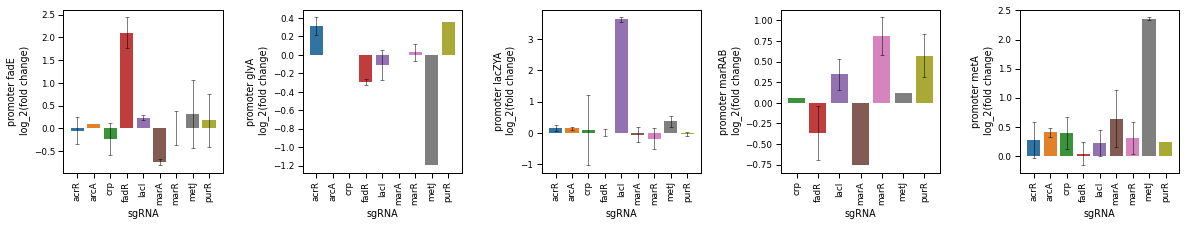

In [16]:
# Fig. S6c
sns.set_context("paper")
fig, axes = plt.subplots(1,5, figsize=(20,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
promoter_list = ['fadE','glyA','lacZYA','marRAB','metA']
for i in range(5):
    data = benchmark_comparison[(benchmark_comparison['operon']==promoter_list[i])&(benchmark_comparison['sgRNA']!='NC_84')]
    sns.barplot(data = data, 
                x = 'sgRNA', 
                y = 'PPTP_response',
                ax = axes[i])
    axes[i].errorbar(x = np.linspace(0,data.shape[0]-1,data.shape[0]), 
                y = data['PPTP_response'],
    #             xerr=data[sort_seq_std],
                yerr=data['PPTP_std']/np.log10(2),
                linewidth=1, linestyle='', capsize = 2, color='k', alpha=0.5)
    axes[i].tick_params(axis='x', rotation=90);
    axes[i].set(ylabel='promoter '+ promoter_list[i] +'\n log_2(fold change)')
